Task : Implement an econometric model for predicting gold price evolution
explain models of choice and final forcasts

In [1]:
import itertools
import numpy as np
import pyflux as pf
import scipy.stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader.data as web
from pandas import DataFrame
import datetime
import quandl
%matplotlib inline
%config InlineBackend.figure_formats=['png']

In [2]:
start = datetime.datetime(1975, 1, 1)
end = datetime.datetime(2017, 1, 27)

##data source quandl = gold priced in USD
data = quandl.get("BUNDESBANK/BBK01_WT5511", authtoken="LSQt2S1x-abvHTx_Lavx")

In [3]:
data.tail()

,Value
Date,
2016-04-12,1259.20
2016-04-13,1245.75
2016-04-14,1240.30
2016-04-15,1229.75
2016-04-18,1237.70


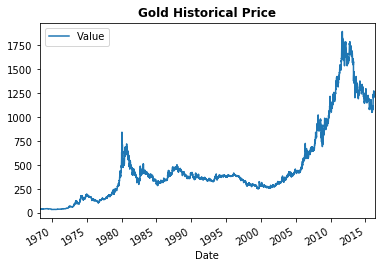

In [4]:
data.plot(y="Value")
plt.title(u"Gold Historical Price", weight='bold');

VAR - Value At Risk Model

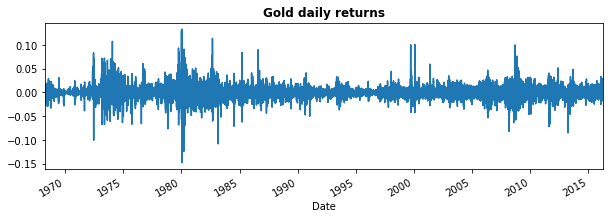

In [5]:
fig = plt.figure()
fig.set_size_inches(10,3)
data["Value"].pct_change().plot()
plt.title(u"Gold daily returns", weight='bold');

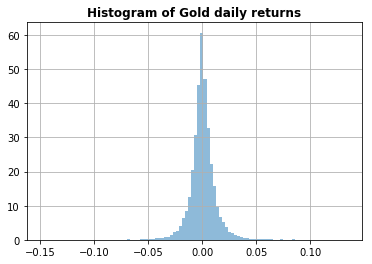

In [6]:
data["Value"].pct_change().hist(bins=100, normed=True, histtype='stepfilled', alpha=0.5)
plt.title(u"Histogram of Gold daily returns", weight='bold')

In [7]:
data["Value"].pct_change().std()

0.012800532647021069

Let's see whether the daily returns are better represented by a normal distribution or by a Student-t distribution

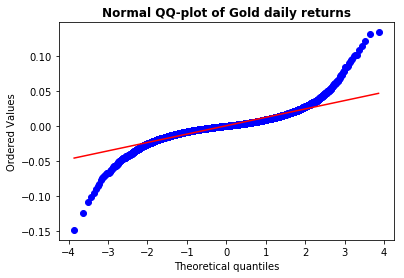

In [8]:
g = data["Value"].pct_change().dropna().as_matrix()
scipy.stats.probplot(g, dist=scipy.stats.norm, plot=plt.figure().add_subplot(111))
plt.title(u"Normal QQ-plot of Gold daily returns", weight="bold");

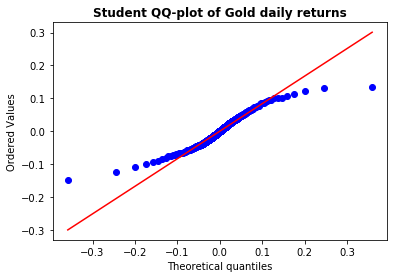

In [9]:
tdf, tmean, tsigma = scipy.stats.t.fit(g)
scipy.stats.probplot(g, dist=scipy.stats.t, sparams=(tdf, tmean, tsigma), plot=plt.figure().add_subplot(111))
plt.title(u"Student QQ-plot of Gold daily returns", weight="bold");

Var Using Historical Bootstrap Method
Calculate empirical quantiles from histogram of daily returns

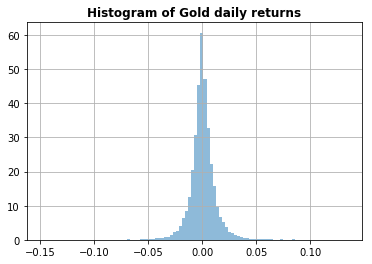

In [10]:
mean = data["Value"].pct_change().mean()
sigma = data["Value"].pct_change().std()
data["Value"].pct_change().hist(bins=100, normed=True, histtype='stepfilled', alpha=0.5)
plt.title(u"Histogram of Gold daily returns", weight='bold')

In [11]:
data["Value"].pct_change().quantile(0.05)

-0.017658176728977515

The 0.05 empirical quantile of daily returns is at -0.017. That means that with 95% confidence, our worst daily loss will not exceed 3.4%.

VAR at Risk Using the Variance-Covariance Method

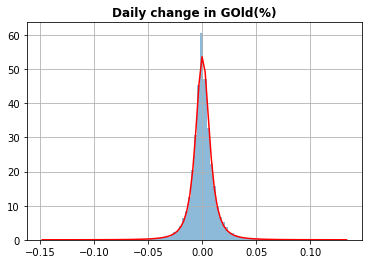

In [12]:
import numpy as np
support = np.linspace(data["Value"].pct_change().min(), data["Value"].pct_change().max(), 100)
data["Value"].pct_change().hist(bins=100, normed=True, histtype='stepfilled', alpha=0.5);
plt.plot(support, scipy.stats.t.pdf(support, loc=tmean, scale=tsigma, df=tdf), "r-")
plt.title(u"Daily change in GOld(%)", weight='bold');

In [13]:
scipy.stats.norm.ppf(0.05, mean, sigma)

-0.020686542521542159

Our analytic 0.05 quantile is at -0.0206, so with 95% confidence, our worst daily loss will not exceed 2.06%

ARIMA Model 

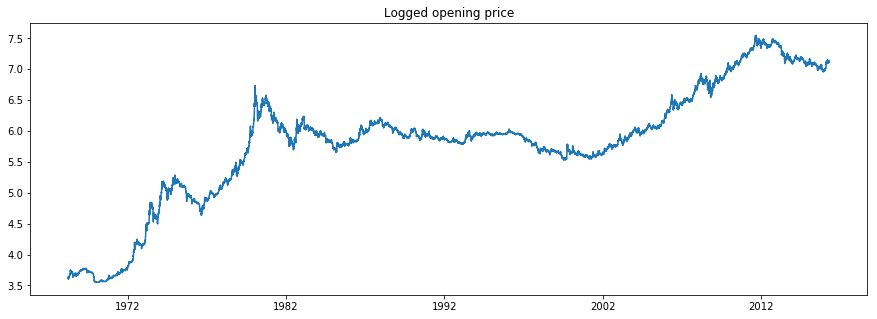

In [18]:
import numpy as np
import pandas as pd
from pandas_datareader import data, wb
import pyflux as pf
import datetime
import matplotlib.pyplot as plt
%matplotlib inline 
start = datetime.datetime(2004, 11, 22)
end = datetime.datetime(2017, 1, 27)

##data source quandl = gold priced in USD
#gld = data.DataReader(['GLD'],  'google', start, end)


##data source quandl = gold priced in USD
gld = quandl.get("BUNDESBANK/BBK01_WT5511", authtoken="LSQt2S1x-abvHTx_Lavx",index_col=['Date','Value'])
#gld.index = gld['Date','Value'].values

opening_prices = np.log(gld['Value'])
plt.figure(figsize=(15,5));
plt.plot(opening_prices.index,opening_prices);
#plt.legend(opening_prices.columns.values,loc=3);
plt.title("Logged opening price");


VAR specifications and see which one minimizes the AIC. Here we just opt for VAR(2) model, which we fit via OLS:

In [19]:
gld.head()

,Value
Date,
1968-04-01,38.0
1968-04-02,37.6
1968-04-03,37.7
1968-04-04,36.7
1968-04-05,37.2


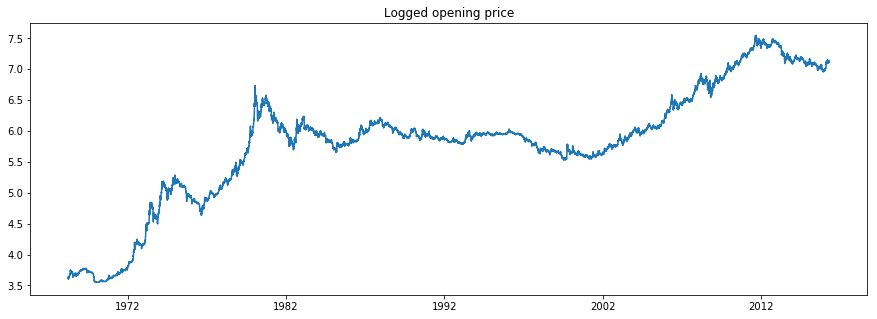

In [20]:
op = np.log(gld['Value'])
plt.figure(figsize=(15,5));
plt.plot(opening_prices.index,opening_prices);
#plt.legend(opening_prices.columns.values,loc=3);
plt.title("Logged opening price");

In [21]:
op.tail()

Date
2016-04-12    7.138232
2016-04-13    7.127493
2016-04-14    7.123109
2016-04-15    7.114566
2016-04-18    7.121010
Name: Value, dtype: float64

In [22]:
op = pd.DataFrame(op)
op.tail()

,Value
Date,
2016-04-12,7.138232
2016-04-13,7.127493
2016-04-14,7.123109
2016-04-15,7.114566
2016-04-18,7.121010


In [23]:
model = pf.ARIMA(data=op,ar=4,ma=4,integ=0,target='Value')

In [24]:
x = model.fit("MLE")
x.summary()

Normal ARIMA(4,0,4)                                                                                       
======================================================= ==================================================
Dependent Variable: Value                               Method: MLE                                       
Start Date: 1968-04-05 00:00:00                         Log Likelihood: -911.3265                         
End Date: 2016-04-18 00:00:00                           AIC: 1842.6531                                    
Number of observations: 12148                           BIC: 1916.7023                                    
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Constant                                 5.6331     0.0727     77.4581  0.0      (5.4906 | 5.7757)        
AR(1)                                

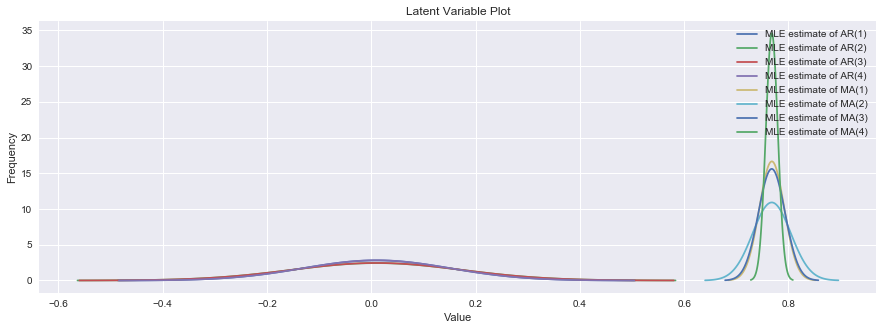

In [25]:
model.plot_z(indices=range(1,9))

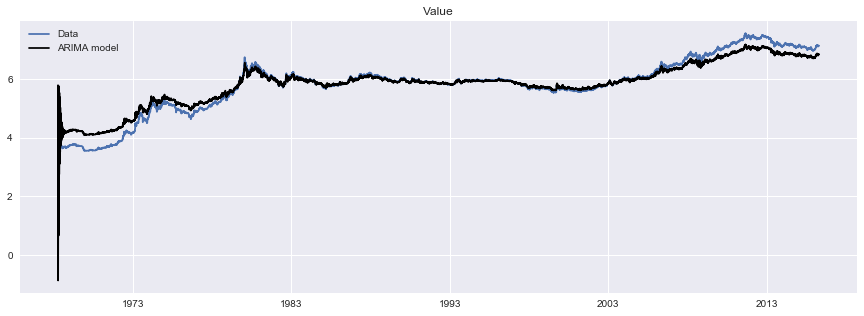

In [26]:
model.plot_fit(figsize=(15,5))

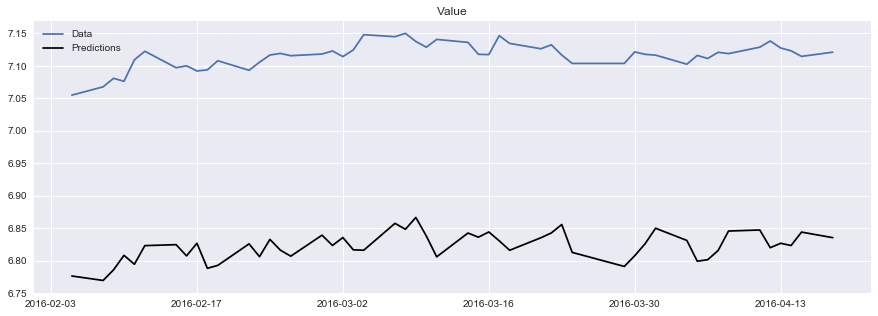

In [27]:
model.plot_predict_is(50,figsize=(15,5))

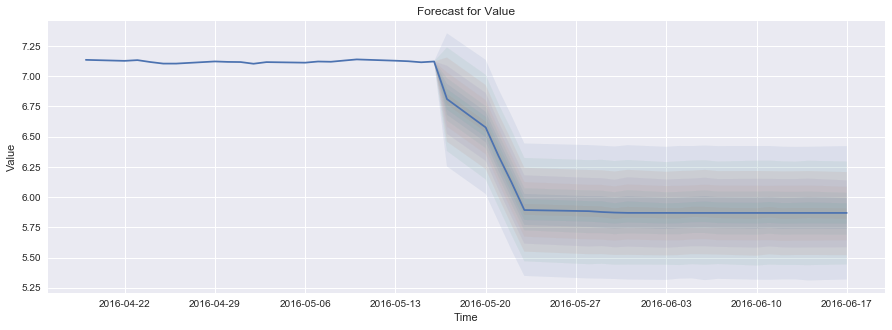

In [28]:
model.plot_predict(h=20,past_values=20,figsize=(15,5))

In [29]:
model.predict(h=20)

,Value
Date,
2016-05-17,6.810342
2016-05-20,6.575834
2016-05-21,6.339517
2016-05-22,6.122811
2016-05-23,5.892879
2016-05-28,5.883661
2016-05-29,5.876694
2016-05-30,5.872022
2016-05-31,5.869478


GARCH Model

In [30]:
import numpy as np
import pandas as pd
from pandas_datareader import data, wb
import pyflux as pf
import datetime
import matplotlib.pyplot as plt
%matplotlib inline 
start = datetime.datetime(2004, 11, 22)
end = datetime.datetime(2017, 1, 27)

##data source quandl = gold priced in USD
#gld = data.DataReader(['GLD'],  'google', start, end)


##data source quandl = gold priced in USD
gold = quandl.get("BUNDESBANK/BBK01_WT5511", authtoken="LSQt2S1x-abvHTx_Lavx",index_col=['Date','Value'])
#gld.index = gld['Date','Value'].values

In [31]:
gc = pd.DataFrame(gold)
gc.tail()

,Value
Date,
2016-04-12,1259.20
2016-04-13,1245.75
2016-04-14,1240.30
2016-04-15,1229.75
2016-04-18,1237.70


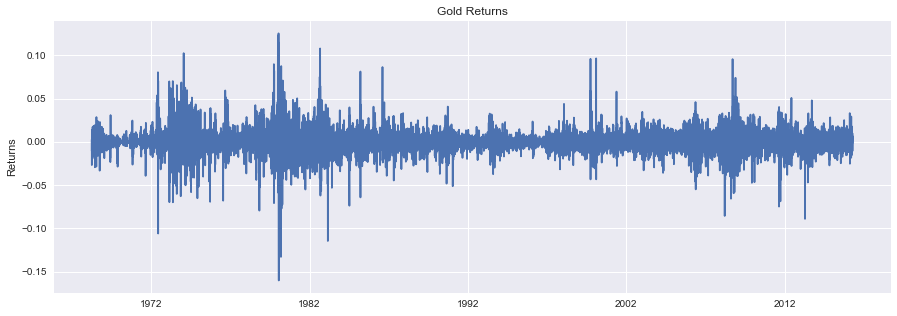

In [32]:
returns = pd.DataFrame(np.diff(np.log(gc['Value'].values)))
returns.index = gc.index.values[1:gc.index.values.shape[0]]
returns.columns = ['GOLD Returns']

plt.figure(figsize=(15,5));
plt.plot(returns.index,returns);
plt.ylabel('Returns');
plt.title('Gold Returns');

One way to visualize the underlying volatility of the series is to plot the absolute returns \mid{y}\mid:

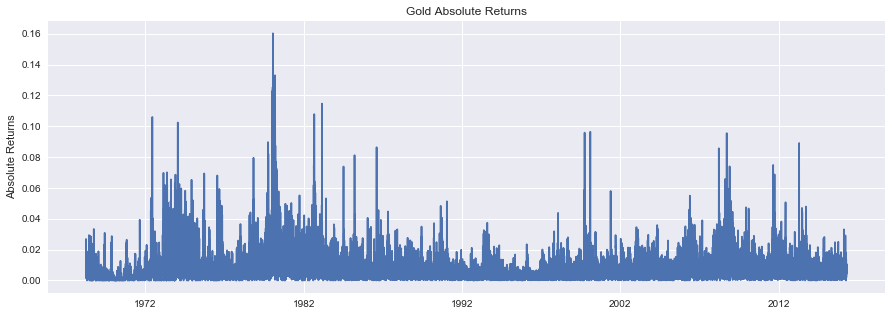

In [33]:
plt.figure(figsize=(15,5))
plt.plot(returns.index, np.abs(returns))
plt.ylabel('Absolute Returns')
plt.title('Gold Absolute Returns');

There appears to be some evidence of volatility clustering over this period. Let’s fit a GARCH(1,1) model using a point mass estimate

In [34]:
model = pf.GARCH(returns,p=1,q=1)
x = model.fit()
x.summary()

GARCH(1,1)                                                                                                
======================================================= ==================================================
Dependent Variable: GOLD Returns                        Method: MLE                                       
Start Date: 1968-04-03 00:00:00                         Log Likelihood: 38772.7827                        
End Date: 2016-04-18 00:00:00                           AIC: -77537.5653                                  
Number of observations: 12150                           BIC: -77507.945                                   
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Vol Constant                             0.0                                                              
q(1)                                 

plot the GARCH parameters with plot_z

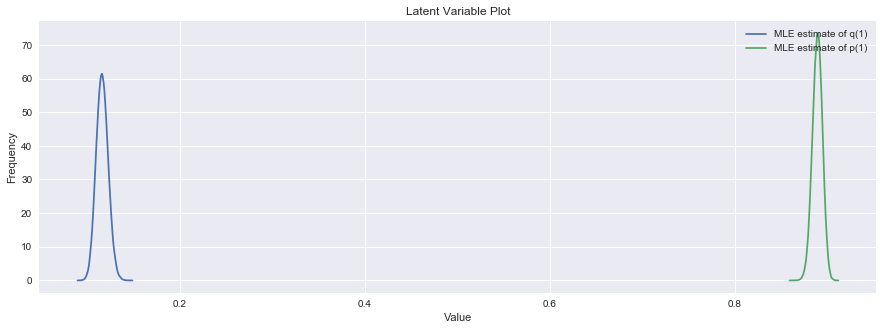

In [35]:
model.plot_z([1,2],figsize=(15,5))

 plot the fit with plot_fit:

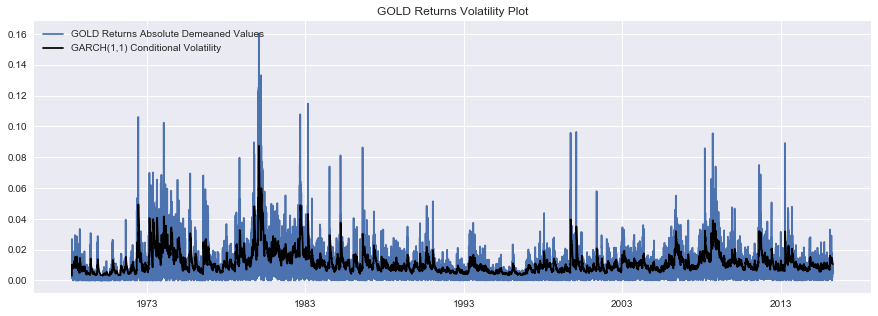

In [36]:
model.plot_fit(figsize=(15,5))

In [37]:
model.predict(h=10)

,GOLD Returns
2016-05-05,0.000107
2016-05-06,0.000114
2016-05-07,0.000122
2016-05-08,0.000128
2016-05-11,0.000134
2016-05-12,0.000139
2016-05-13,0.000145
2016-05-14,0.000149
2016-05-15,0.000153
2016-05-18,0.000155


how well we predicted using dynamic in-sample rolling prediction with plot_predict_is

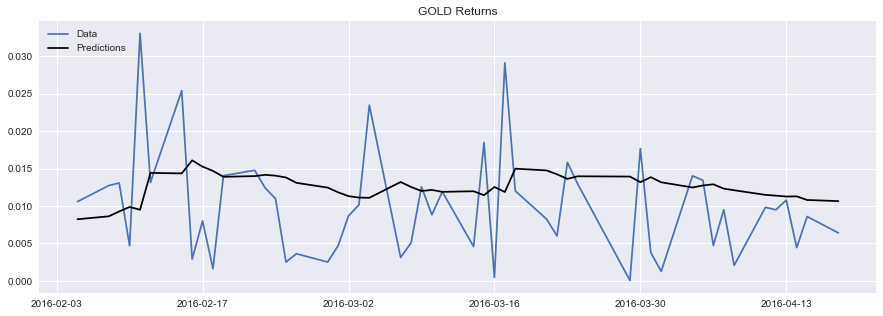

In [38]:
model.plot_predict_is(h=50,figsize=(15,5))

Bayesian regression - Sci-Kit Learn Regression

In [9]:
import pandas as pd
from pandas_datareader import data, wb

import numpy as np
import matplotlib.pyplot as plt
import datetime
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller

%matplotlib inline

In [10]:
start = datetime.datetime(2007, 1, 1)
end = datetime.datetime(2017, 1, 1)
data = data.DataReader(['GLD','UUP','TLT'],  'google', start, end)

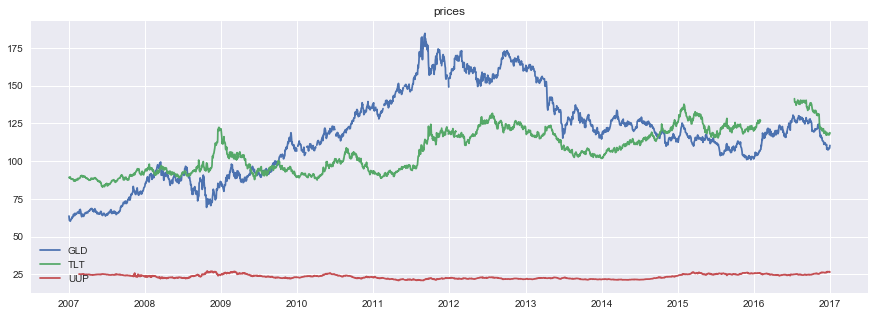

In [11]:
fx_data =data['Open']
plt.figure(figsize=(15,5));
plt.plot(fx_data.index,fx_data);
plt.legend(fx_data.columns.values,loc=3);
plt.title("prices");

In [14]:
fx_data.tail()

,GLD,TLT,UUP
Date,,,
2016-12-23,107.84,118.24,26.65
2016-12-27,108.61,117.42,26.65
2016-12-28,108.40,117.86,26.73
2016-12-29,109.23,118.80,26.63
2016-12-30,110.38,118.78,26.44


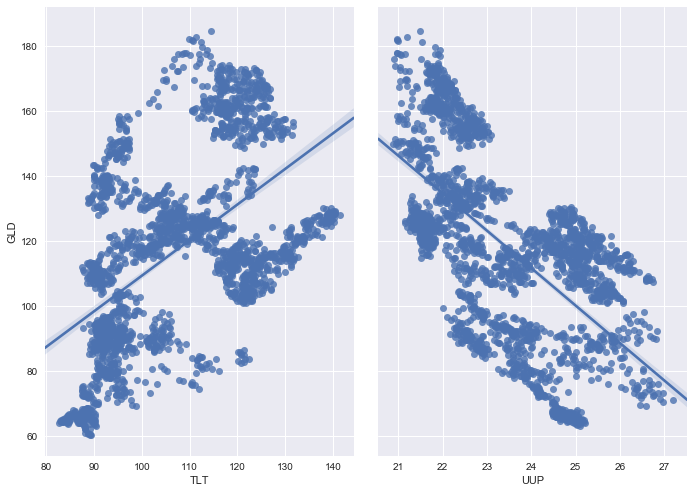

In [16]:
# conventional way to import seaborn
import seaborn as sns

# allow plots to appear within the notebook
%matplotlib inline
# visualize the relationship between the features and the response using scatterplots
sns.pairplot(fx_data, x_vars=['TLT','UUP'], y_vars='GLD', size=7, aspect=0.7, kind='reg')

Linear regression
Pros: fast, no tuning required, highly interpretable, well-understood
Cons: unlikely to produce the best predictive accuracy (presumes a linear relationship between the features and response)

In [32]:
fx_data = fx_data.apply(np.int64)
fx_data.tail()

,GLD,TLT,UUP
Date,,,
2016-12-23,107,118,26
2016-12-27,108,117,26
2016-12-28,108,117,26
2016-12-29,109,118,26
2016-12-30,110,118,26


In [33]:
X = fx_data[['TLT','UUP']]
# check the type and shape of X
print(type(X))
print(X.shape)

<class 'pandas.core.frame.DataFrame'>
(2517, 2)


In [34]:
# select a Series from the DataFrame
y = fx_data['GLD']

# equivalent command that works if there are no spaces in the column name
y = fx_data.GLD

# print the first 5 values
y.head()

Date
2007-01-03    63
2007-01-04    62
2007-01-05    60
2007-01-08    60
2007-01-09    60
Name: GLD, dtype: int64

In [35]:
# check the type and shape of y
print(type(y))
print(y.shape)

<class 'pandas.core.series.Series'>
(2517,)


Splitting X and y into training and testing sets

In [36]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [37]:
# default split is 75% for training and 25% for testing
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1887, 2)
(1887,)
(630, 2)
(630,)


##Linearegression in scikit-learn

In [38]:
# import model
from sklearn.linear_model import LinearRegression

# instantiate
linreg = LinearRegression()

# fit the model to the training data (learn the coefficients)
linreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Interpreting model coefficients

In [39]:
# print the intercept and coefficients
print(linreg.intercept_)
print(linreg.coef_)

3.90449658829e+16
[ 0.09101517  0.2912811 ]


In [40]:
# pair the feature names with the coefficients
list(zip(feature_cols, linreg.coef_))

[('TLT', 0.091015169194866061), ('UUP', 0.29128110499036652)]

How do we interpret the Tltlcoefficient (0.09101)?
For a given amount TLT increase, a unit of GLD increase is 0.0466 "unit" increase in the Dollar

In [42]:
# make predictions on the testing set
y_pred = linreg.predict(X_test)

In [43]:
# define true and predicted response values
true = [100, 50, 30, 20]
pred = [90, 50, 50, 30]

In [44]:
# calculate MAE by hand
print((10 + 0 + 20 + 10)/4.)

# calculate MAE using scikit-learn
from sklearn import metrics
print(metrics.mean_absolute_error(true, pred))

10.0
10.0


In [45]:
# calculate MSE by hand
print((10**2 + 0**2 + 20**2 + 10**2)/4.)

# calculate MSE using scikit-learn
print(metrics.mean_squared_error(true, pred))

150.0
150.0


In [46]:
# calculate RMSE by hand
import numpy as np
print(np.sqrt((10**2 + 0**2 + 20**2 + 10**2)/4.))

# calculate RMSE using scikit-learn
print(np.sqrt(metrics.mean_squared_error(true, pred)))

12.2474487139
12.2474487139


In [47]:
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

6.48195291447e+17


ARCH- VAR Modeling

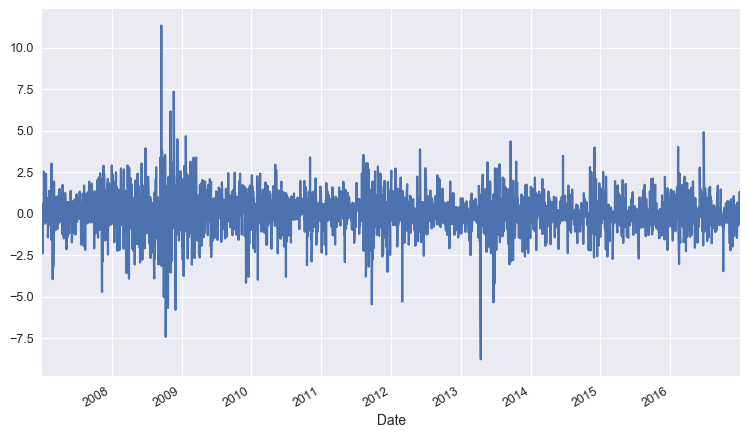

In [50]:
import pandas as pd
from pandas_datareader import data, wb
%matplotlib inline
import seaborn
seaborn.mpl.rcParams['figure.figsize'] = (10.0, 6.0)
seaborn.mpl.rcParams['savefig.dpi'] = 90

data = data.DataReader('GLD',  'google', start, end)
returns = 100 * data['Close'].pct_change().dropna()
figure = returns.plot()

GARCH (with Constant MEAN)

In [52]:
from arch import arch_model
am = arch_model(returns) 
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     40,   Neg. LLF: 3900.8981600048874
Iteration:     10,   Func. Count:     72,   Neg. LLF: 3900.565179367569
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3900.56517936
            Iterations: 10
            Function evaluations: 72
            Gradient evaluations: 10
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  Close   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:               -3900.57
Distribution:                  Normal   AIC:                           7809.13
Method:            Maximum Likelihood   BIC:                           7832.45
                                        No. Observations:                 2516
Date:                Sat, May 20 2017   Df Residuals:                     2512
Time:            

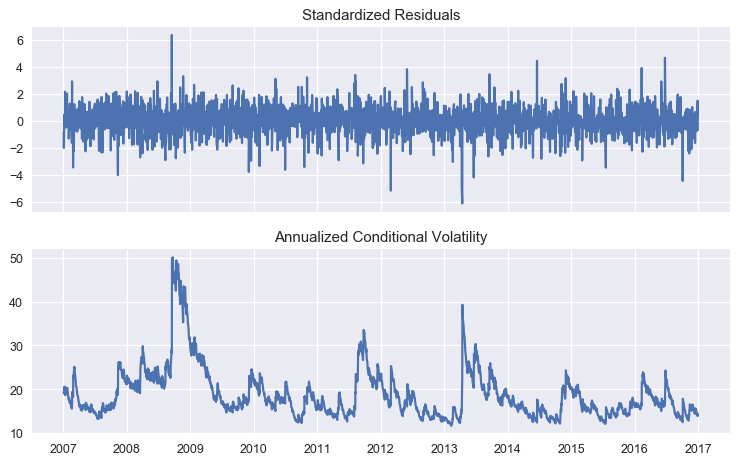

In [53]:
fig = res.plot(annualize='D')

GJR-GARCH

In [54]:
am = arch_model(returns, p=1, o=1, q=1)
res = am.fit(update_freq=5, disp='off')
print(res.summary())

                   Constant Mean - GJR-GARCH Model Results                    
Dep. Variable:                  Close   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:               -3900.53
Distribution:                  Normal   AIC:                           7811.06
Method:            Maximum Likelihood   BIC:                           7840.21
                                        No. Observations:                 2516
Date:                Sat, May 20 2017   Df Residuals:                     2511
Time:                        12:05:26   Df Model:                            5
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu             0.0230  2.150e-02      1.072      0.284 

TARCH/ZARCH
TARCH (also known as ZARCH) model the volatility using absolute values

In [55]:
am = arch_model(returns, p=1, o=1, q=1, power=1.0)
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     48,   Neg. LLF: 3909.669086213341
Iteration:     10,   Func. Count:     87,   Neg. LLF: 3904.5063693731563
Iteration:     15,   Func. Count:    125,   Neg. LLF: 3904.5061894933924
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3904.50618729
            Iterations: 16
            Function evaluations: 134
            Gradient evaluations: 16
                  Constant Mean - TARCH/ZARCH Model Results                   
Dep. Variable:                  Close   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                TARCH/ZARCH   Log-Likelihood:               -3904.51
Distribution:                  Normal   AIC:                           7819.01
Method:            Maximum Likelihood   BIC:                           7848.16
                                        No. Observations:                 2516
Date:                S

**Student's T Errors**
Financial returns are often heavy tailed, and a Student's T distribution is a simple method to capture this feature. The call to arch changes the distribution from a Normal to a Students's T.

The standardized residuals appear to be heavy tailed with an estimated degree of freedom near 10. The log-likelihood also shows a large increase.

In [56]:
am = arch_model(returns, p=1, o=1, q=1, power=1.0, dist='StudentsT')
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     53,   Neg. LLF: 3814.338875321925
Iteration:     10,   Func. Count:     96,   Neg. LLF: 3803.5212887674716
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3803.52096107
            Iterations: 12
            Function evaluations: 112
            Gradient evaluations: 12
                     Constant Mean - TARCH/ZARCH Model Results                      
Dep. Variable:                        Close   R-squared:                      -0.000
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      TARCH/ZARCH   Log-Likelihood:               -3803.52
Distribution:      Standardized Student's t   AIC:                           7619.04
Method:                  Maximum Likelihood   BIC:                           7654.02
                                              No. Observations:                 2516
Date:                      Sat, May 20 2017   Df Resi